In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_geometric.nn import GATConv
import pickle
from tqdm import tqdm
import numpy as np
from torch.functional import F
import matplotlib.pyplot as plt


with open("data/train_graphs_data.pkl", "rb") as file:
    graphs = pickle.load(file)
    file.close()

In [14]:
len(graphs), graphs[0]

(90,
 Data(x=[1140, 33], edge_index=[2, 11709], edge_attr=[11709, 2], y=[1140, 2]))

In [15]:
graphs[0].y[0]

tensor([-0.2741, -0.6940])

In [16]:
# 划分训练集和验证集，使用sklearn的train_test_split函数
from sklearn.model_selection import train_test_split

train_graphs, val_graphs = train_test_split(graphs, test_size=0.05, random_state=42)

In [17]:
class GATModel(nn.Module):
    def __init__(self, input_size, output_size, num_heads=2):
        super(GATModel, self).__init__()
        # nn.Sequential不方便处理多个输入，所以这里只能用两个GATConv

        # 观察下来觉得一个GATConv就够了
        # 也许需要再验证一下

        # conv层的output_size是指每个head的输出维度，而不是总的维度
        self.conv1 = GATConv(input_size, 48, heads=num_heads, dropout=0.1)

        self.regression = nn.Sequential(
            nn.Linear(48 * num_heads, 32),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, output_size),
        )

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        output = F.relu(self.conv1(x, edge_index, edge_attr))
        output = self.regression(output)

        return output

In [18]:
# 看看模型的输入输出
model = GATModel(input_size=33, output_size=2, num_heads=2)
output = model(graphs[0])
output.shape

torch.Size([1140, 2])

In [19]:
input_size = graphs[0].x.shape[1]
# 这里的output_size就是最终的输出维度，不需要再乘以num_heads
output_size = graphs[0].y.shape[1]
# 个人认为，注意力头的个数应该和输出维度保持一致，因为每个输出可能需要关注不同的邻居
num_heads = graphs[0].y.shape[1]

lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 50
# batch_size = 256

# 开始训练

In [20]:
def train(train_graphs, val_graphs=None, num_epochs=50):
    # 定义模型、算法、损失函数
    model = GATModel(
        input_size=input_size,
        output_size=output_size,
        num_heads=num_heads,
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # 训练过程记录
    train_loss_list = []
    if val_graphs:
        val_loss_list = []

    with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar_epochs:
        for epoch in range(num_epochs):
            # 训练
            model.train()
            train_loss = 0.0

            # 目前每个batch是1个graph
            for i, graph in enumerate(train_graphs):
                graph = graph.to(device)

                output = model(graph)

                optimizer.zero_grad()
                loss = criterion(output, graph.y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_graphs)
            train_loss_list.append(train_loss)

            # 验证
            if val_graphs:
                model.eval()
                with torch.no_grad():
                    val_loss = 0.0
                    for i, graph in enumerate(val_graphs):
                        graph = graph.to(device)
                        output = model(graph)
                        loss = criterion(output, graph.y)
                        val_loss += loss.item()
                    val_loss /= len(val_graphs)
                    val_loss_list.append(val_loss)

            if val_graphs:
                pbar_epochs.set_postfix(
                    {"train MSE Loss": train_loss, "val MSE Loss": val_loss}
                )
            else:
                pbar_epochs.set_postfix({"train MSE Loss": train_loss})
            pbar_epochs.update(1)

    # 可视化训练过程
    plt.figure()
    plt.plot(train_loss_list, label="train loss")
    if val_graphs:
        plt.plot(val_loss_list, label="val loss")
    plt.xlabel("epoch")
    plt.ylabel("MSE loss")
    plt.legend()

    return model

Training Progress: 100%|██████████| 50/50 [00:18<00:00,  2.66epoch/s, train MSE Loss=0.276, val MSE Loss=0.272]


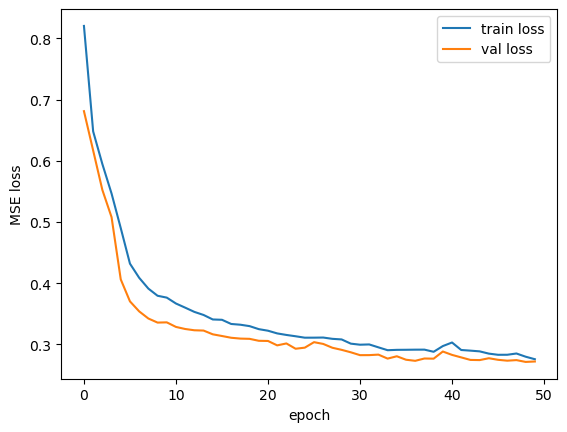

In [21]:
model = train(train_graphs, val_graphs)

Training Progress: 100%|██████████| 80/80 [00:30<00:00,  2.63epoch/s, train MSE Loss=0.278]


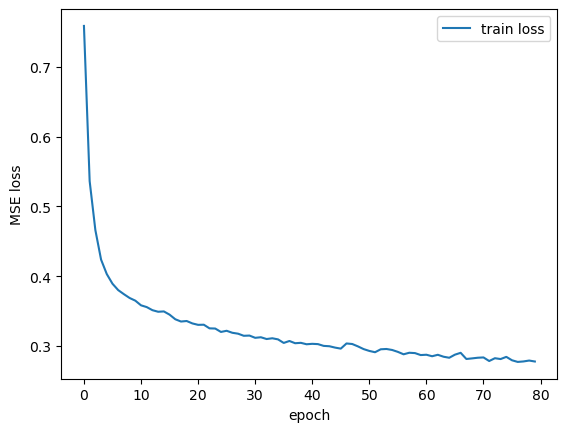

In [22]:
# 所有数据都用来训练
model = train(graphs, num_epochs=80)

In [26]:
# 保存模型
torch.save(model.state_dict(), "models/GAT.pth")

# 预测

In [34]:
# 读取模型
model = GATModel(
    input_size=input_size,
    output_size=output_size,
    num_heads=num_heads,
).to(device)
model.load_state_dict(torch.load("models/GAT.pth"))

<All keys matched successfully>

In [35]:
# 读取node_ids
with open("data/node_ids.pkl", "rb") as file:
    node_ids = pickle.load(file)
    file.close()

In [36]:
# 读取scaler
import pickle

with open("saved/scaler/label_scaler.pkl", "rb") as file:
    label_scaler = pickle.load(file)
    file.close()

In [37]:
# 读取测试集
with open("data/test_graphs_data.pkl", "rb") as file:
    test_graphs = pickle.load(file)
    file.close()

In [38]:
len(test_graphs), test_graphs[0]

(4, Data(x=[1140, 33], edge_index=[2, 21018], edge_attr=[21018, 2]))

预测

In [39]:
output_list = []
for i, graph in enumerate(test_graphs):
    graph = graph.to(device)
    output = model(graph)
    output_list.append(output.detach().cpu().numpy())

In [40]:
len(output_list), output_list[0].shape, output_list[0][0]

(4, (1140, 2), array([-0.6753803, -1.427055 ], dtype=float32))

In [42]:
# 缩放
output_list = [label_scaler.inverse_transform(output) for output in output_list]

In [43]:
# 看看是不是缩放完成啦
output_list[0][0]

array([67.92821, 57.41653], dtype=float32)

### 把输出转成需要的格式

In [48]:
import csv

# 结果写入csv，分隔符为\t
date_id = [20230404, 20230405, 20230406, 20230407]
with open("output/GATout.csv", "w", newline="") as f:
    writer = csv.writer(f, delimiter="\t")  # 设置分隔符为制表符
    writer.writerow(["geohash_id", "consumption_level", "activity_level", "date_id"])

    # output_list.shape = [4天, 节点数, 2个输出]
    for nidx in range(len(node_ids)):
        for day in range(len(date_id)):
            # 注意不要写反了
            writer.writerow(
                [
                    node_ids[nidx],
                    output_list[day][nidx][1],
                    output_list[day][nidx][0],
                    date_id[day],
                ]
            )
    f.close()